\**Downloading, Installing & Importing Required Libraries**

In [3]:
import os
import h5py
import math
import torch
from torch.utils.data import Dataset

In [4]:
!pip install transformers
!pip install accelerate -U

In [5]:
from transformers import (
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    PreTrainedTokenizer,
    Trainer,
    TrainingArguments,
    set_seed,
    TrainerCallback
)
import accelerate

/home/hiren20066/BTP_Dev/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-24 12:26:51.323015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 12:26:52.057184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


**Mounting Google Drive for importing the Data Files which will be used in the Tokenization**

**Selecting the GPU to Train the Model**

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

**Defining the Method that will Create the Pytorch Compatible Dataset Class**

In [7]:
class H5Dataset(Dataset):
    def __init__(self, tokenizer, file_path='/home/Dataset_Project/train_temp', block_size=512):
        cached_features_file = "/home/Dataset_Project/data_temp.h5"

        # logger.info("Loading features from cached file %s", cached_features_file)
        print(("Loading features from cached file %s", cached_features_file))
        with h5py.File(cached_features_file, 'r') as f:
            if file_path=='/home/Dataset_Project/test_temp':
                self.samples = f[file_path][:] #this is a dev set, 30% of a test set
            else:
                self.samples = f[file_path][:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, item):
        return torch.tensor(self.samples[item])

In [8]:
def get_dataset( tokenizer, evaluate=False, local_rank=-1):
  file_path = "/home/Dataset_Project/test_temp" if evaluate else "/home/Dataset_Project/train_temp"
  return H5Dataset(tokenizer=tokenizer, file_path=file_path)

**Performing Transformer Configuration**

In [9]:
config = AutoConfig.from_pretrained('gpt2', cache_dir='cache')
set_seed(20)

**Defining the Tokenizer for the Model Training**

In [10]:
tokenizer = AutoTokenizer.from_pretrained('gpt2', cache_dir= 'cache')

**Initialising the GPT2 Model**

In [11]:
model = AutoModelWithLMHead.from_pretrained('gpt2',config=config,cache_dir='cache',)

/home/hiren20066/BTP_Dev/.venv/lib/python3.8/site-packages/transformers/models/auto/modeling_auto.py:1682: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


**Adding the Special Recipe Token to the Tokenizer**

In [12]:
special_tokens = {
    "additional_special_tokens": [
        '<RECIPE_START>',
        '<INPUT_START>',
        '<NEXT_INPUT>',
        '<INPUT_END>',
        '<INGR_START>',
        '<NEXT_INGR>',
        '<INGR_END>',
        '<INSTR_START>',
        '<NEXT_INSTR>',
        '<INSTR_END>',
        '<TITLE_START>',
        '<TITLE_END>',
        '<RECIPE_END>'
    ]
}

**Resizeing the Model to Fit the Tokenizer with Special Tokens**

In [13]:
tokenizer.add_special_tokens(special_tokens)
model.resize_token_embeddings(len(tokenizer))

Embedding(50270, 768)

**Converting the Train and Validation Dataset to Pytorch Dataset so as it can be given to the Model as Input for Training**

In [14]:
train_dataset = (get_dataset(tokenizer=tokenizer))
eval_dataset = (get_dataset(tokenizer=tokenizer, evaluate=True))

('Loading features from cached file %s', '/home/hiren20066/BTP_Dev/Dataset_Project/data_temp.h5')
('Loading features from cached file %s', '/home/hiren20066/BTP_Dev/Dataset_Project/data_temp.h5')


**To be able to build batches, data collators may apply some processing (like padding).Some of them (like DataCollatorForLanguageModeling) also apply some random data augmentation (like random masking) oin the formed batch.
Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.Forming the batches to dataset to be trained
source :- Hugginface.co**

In [15]:
data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False, mlm_probability=0.15  )

In [16]:
import h5py
with h5py.File('/home/Dataset_Project/data_temp.h5', 'r') as f:
    print(list(f.keys()))  # This will print all dataset names or group paths in the HDF5 file


['home']


In [17]:
training_args = TrainingArguments(
    output_dir="/home/Dataset_Project/project_model",
    logging_dir="/home/Dataset_Project/logs",  # Directory for the logs
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    evaluation_strategy="steps",
    eval_steps=500,  # Add this to perform evaluation every 500 steps
    save_strategy="steps",
    save_steps=500,  # Checkpoints will be saved every 500 steps
    logging_steps=10,  # Log training information every 10 steps
    fp16=True,
    fp16_opt_level='O1',
    warmup_steps=100,
    learning_rate=5e-4,
    adam_epsilon=1e-8,
    weight_decay=0.01,
    save_total_limit=3,  # Keep only the 3 most recent checkpoints
    metric_for_best_model="loss",  # Assumes you want to use loss to determine the best model
    greater_is_better=False,  # Lower loss indicates a better model
    report_to="tensorboard",  # Enable logging to TensorBoard
)


**Initializing PyTorch Trainer**

In [18]:

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)


/home/hiren20066/BTP_Dev/.venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


**Saving the Tokenizer Object & Starting Training and Saving the model after Finishing the training**

In [19]:
# Clears the cached memory blocks in the GPU's caching allocator.
# This can help if you are running into GPU memory fragmentation issues.
torch.cuda.empty_cache()

# Additionally, if you want to ensure that all the tensors you created
# are no longer in use (and thus can be cleared from memory), you can
# manually delete them and optionally run Python's garbage collector.
#del your_tensor_variable  # Replace your_tensor_variable with your tensor's name
torch.cuda.synchronize()  # Waits for all kernels in all streams on a CUDA device to complete.

import gc
gc.collect()  # Runs Python's garbage collector

# Note: del and gc.collect() are Python's way of ensuring that objects are deleted.
# PyTorch relies on Python's garbage collection to free up memory, so these commands can be useful.
# However, they will only free memory for objects that no longer have any references to them.\

26

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
tokenizer.save_pretrained('/home/Dataset_Project/project_model')
trainer.train()
trainer.save_model()

Step,Training Loss,Validation Loss
500,1.343800,1.276573
1000,1.211000,1.196644
1500,1.176400,1.156363
2000,1.140400,1.128392


**Saving the Tokenizer**

In [22]:
tokenizer.save_pretrained('/home/Dataset_Project/project_model')

('/home/hiren20066/BTP_Dev/Dataset_Project/project_model/tokenizer_config.json',
 '/home/hiren20066/BTP_Dev/Dataset_Project/project_model/special_tokens_map.json',
 '/home/hiren20066/BTP_Dev/Dataset_Project/project_model/vocab.json',
 '/home/hiren20066/BTP_Dev/Dataset_Project/project_model/merges.txt',
 '/home/hiren20066/BTP_Dev/Dataset_Project/project_model/added_tokens.json',
 '/home/hiren20066/BTP_Dev/Dataset_Project/project_model/tokenizer.json')

In [23]:
import os

model_directory = '/home/Dataset_Project/project_model'

for filename in os.listdir(model_directory):
    file_path = os.path.join(model_directory, filename)
    
    print(f"File available at: {file_path}")

File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/merges.txt
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/model.safetensors
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/training_args.bin
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/vocab.json
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/tokenizer.json
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/config.json
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/checkpoint-1000
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/special_tokens_map.json
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/checkpoint-2000
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/generation_config.json
File available at: /home/hiren20066/BTP_Dev/Dataset_Project/project_model/tokenizer_config.json


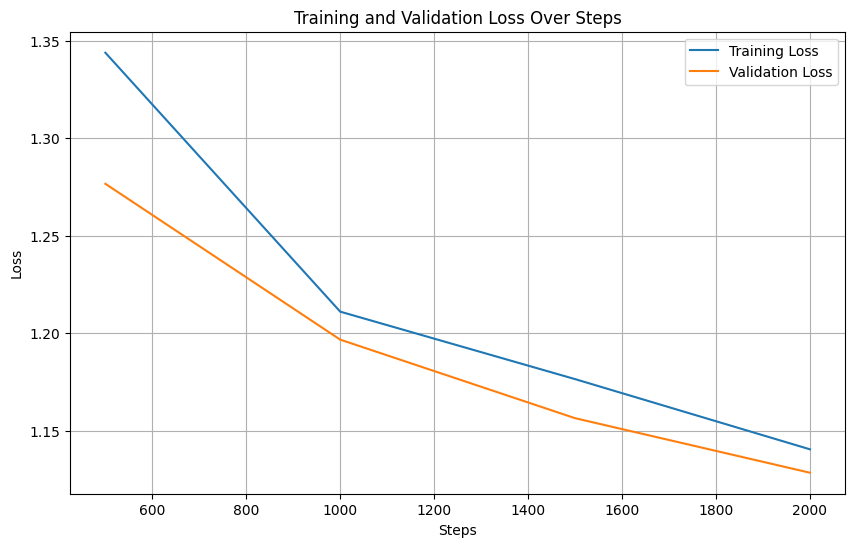

In [26]:
import matplotlib.pyplot as plt

# Assuming you've manually extracted the values from the TensorBoard logs or your own logging mechanism
steps = [500, 1000, 1500, 2000]
training_loss = [1.343800, 1.211000, 1.176400, 1.140400]
validation_loss = [1.276573, 1.196644, 1.156363, 1.128392]

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, label='Training Loss')
plt.plot(steps, validation_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Steps')
plt.legend()
plt.grid(True)
plt.show()
